In [1]:
import os
import gym
import gym_snake
import random
import numpy as np
import tensorflow as tf
from collections import deque
from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook

from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, Dense, Permute, Activation
import keras.backend as K

%matplotlib inline

Using TensorFlow backend.


Grid Size:  [25 25]
Image shape before pre-processing:  (250, 250, 3)
Image shape after pre-processing:  (84, 84)
No. of actions:  4

Before Preprocessing:


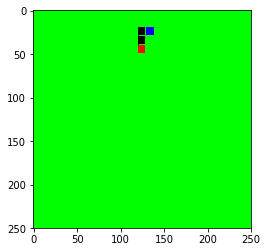


After Preprocessing:


/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


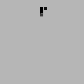

<Figure size 432x288 with 0 Axes>

In [2]:
ENV_NAME = 'snake-v0'  # Environment name
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network (WINDOW LENGTH)

env = gym.make(ENV_NAME)
env.n_foods = 1
env.grid_size = [25, 25]
env.unit_size = 10
env.unit_gap = 1
env.random_init = True
np.random.seed(123)
env.seed(123)
x_t = env.reset()

# Controller
game_controller = env.controller
# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid
print('Grid Size: ', grid_object.grid_size)
# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

state_shape = grid_pixels.shape
print('Image shape before pre-processing: ', state_shape)
print('Image shape after pre-processing: ', (FRAME_WIDTH, FRAME_HEIGHT))
nb_actions = env.action_space.n
print('No. of actions: ', nb_actions)

print('\nBefore Preprocessing:')
env.render()

print('\nAfter Preprocessing:')
from PIL import Image
from IPython.display import display
processed_image = np.uint8(resize(rgb2gray(x_t), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
img = Image.fromarray(processed_image)
display(img)

In [16]:
NUM_STEPS = 10_000_005
GAMMA = 0.99  # Discount factor
EXPLORATION_STEPS = 7_000_000  # Number of steps over which the initial value of epsilon is linearly annealed to its final value
INITIAL_EPSILON = 1.0  # Initial value of epsilon in epsilon-greedy
FINAL_EPSILON = 0.1  # Final value of epsilon in epsilon-greedy
INITIAL_REPLAY_SIZE = 20_000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 400_000  # Number of replay memory the agent uses for training
BATCH_SIZE = 32  # Mini batch size
TARGET_UPDATE_INTERVAL = 7000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects 4 actions between successive updates
LEARNING_RATE = 0.00025  # Learning rate used by RMSProp
MOMENTUM = 0.95  # Momentum used by RMSProp
MIN_GRAD = 0.01  # Constant added to the squared gradient in the denominator of the RMSProp update
SAVE_INTERVAL = 500_000  # The frequency with which the network is saved
NO_OP_STEPS = 10  # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode

LOAD_NETWORK = False

SAVE_NETWORK_PATH = 'saved_networks/' + ENV_NAME
SAVE_SUMMARY_PATH = 'summary/' + ENV_NAME
NUM_EPISODES_AT_TEST = 30  # Number of episodes the agent plays at test time

In [17]:
class Agent():
    def __init__(self, num_actions):
        self.num_actions = num_actions
        
        self.epsilon = INITIAL_EPSILON
        self.epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS
        self.t = 0

        # Parameters used for summary
        self.total_reward = 0
        self.total_q_max = 0
        self.total_loss = 0
        self.duration = 0
        self.episode = 0

        # Create replay memory
        self.replay_memory = deque()

        # Create q network
        self.s, self.q_values, self.q_network = self.build_network()
        print(self.q_network.summary())
        q_network_weights = self.q_network.trainable_weights

        # Create target network
        self.st, self.target_q_values, target_network = self.build_network()
        target_network_weights = target_network.trainable_weights

        # Define target network update operation
        self.update_target_network = [target_network_weights[i].assign(q_network_weights[i]) for i in
                                      range(len(target_network_weights))]

        # Define loss and gradient update operation
        self.a, self.y, self.loss, self.grads_update = self.build_training_op(q_network_weights)

        self.sess = tf.InteractiveSession()
        self.saver = tf.train.Saver(q_network_weights)
        self.summary_placeholders, self.update_ops, self.summary_op = self.setup_summary()
        self.summary_writer = tf.summary.FileWriter(SAVE_SUMMARY_PATH, self.sess.graph)

        if not os.path.exists(SAVE_NETWORK_PATH):
            os.makedirs(SAVE_NETWORK_PATH)

        self.sess.run(tf.initialize_all_variables())

        # Load network
        if LOAD_NETWORK:
            self.load_network()

        # Initialize target network
        self.sess.run(self.update_target_network)

    def build_network(self):
        input_shape = (STATE_LENGTH,) + (FRAME_WIDTH, FRAME_HEIGHT)
        model = Sequential()
        if K.image_dim_ordering() == 'tf':
            # (width, height, channels)
            model.add(Permute((2, 3, 1), input_shape=input_shape))
        elif K.image_dim_ordering() == 'th':
            # (channels, width, height)
            model.add(Permute((1, 2, 3), input_shape=input_shape))
        else:
            raise RuntimeError('Unknown image_dim_ordering.')

        model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(self.num_actions))
        model.add(Activation('linear'))

        s = tf.placeholder(tf.float32, [None, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT])
        q_values = model(s)

        return s, q_values, model

    def build_training_op(self, q_network_weights):
        a = tf.placeholder(tf.int64, [None])
        y = tf.placeholder(tf.float32, [None])

        # Convert action to one hot vector
        a_one_hot = tf.one_hot(a, self.num_actions, 1.0, 0.0)
        q_value = tf.reduce_sum(tf.multiply(self.q_values, a_one_hot), reduction_indices=1)

        # Clip the error, the loss is quadratic when the error is in (-1, 1), and linear outside of that region
        error = tf.abs(y - q_value)
        quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)

        optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, momentum=MOMENTUM, epsilon=MIN_GRAD)
        grads_update = optimizer.minimize(loss, var_list=q_network_weights)

        return a, y, loss, grads_update

    def get_initial_state(self, observation, last_observation):
        processed_observation = np.maximum(observation, last_observation)
        processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
        state = [processed_observation for _ in range(STATE_LENGTH)]
        return np.stack(state, axis=0)

    def get_action(self, state):
        if self.epsilon >= random.random() or self.t < INITIAL_REPLAY_SIZE:
            action = random.randrange(self.num_actions)
        else:
            action = np.argmax(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))

        # Anneal epsilon linearly over time
        if self.epsilon > FINAL_EPSILON and self.t >= INITIAL_REPLAY_SIZE:
            self.epsilon -= self.epsilon_step

        return action

    def run(self, state, action, reward, terminal, observation):
        next_state = np.append(state[1:, :, :], observation, axis=0)

        # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
        reward = np.clip(reward, -1, 1)

        # Store transition in replay memory
        self.replay_memory.append((state, action, reward, next_state, terminal))
        if len(self.replay_memory) > NUM_REPLAY_MEMORY:
            self.replay_memory.popleft()

        if self.t >= INITIAL_REPLAY_SIZE:
            # Train network
            if self.t % TRAIN_INTERVAL == 0:
                self.train_network()

            # Update target network
            if self.t % TARGET_UPDATE_INTERVAL == 0:
                self.sess.run(self.update_target_network)

            # Save network
            if self.t % SAVE_INTERVAL == 0:
                save_path = self.saver.save(self.sess, SAVE_NETWORK_PATH + '/' + ENV_NAME, global_step=self.t)
                print('Successfully saved: ' + save_path)

        self.total_reward += reward
        self.total_q_max += np.max(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))
        self.duration += 1

        if terminal:
            # Write summary
            if self.t >= INITIAL_REPLAY_SIZE:
                stats = [self.total_reward, self.total_q_max / float(self.duration),
                         self.duration, self.total_loss / (float(self.duration) / float(TRAIN_INTERVAL)), float(self.t)]
                for i in range(len(stats)):
                    self.sess.run(self.update_ops[i], feed_dict={
                        self.summary_placeholders[i]: float(stats[i])
                    })
                summary_str = self.sess.run(self.summary_op)
                self.summary_writer.add_summary(summary_str, self.episode + 1)

            # Debug
            if self.t < INITIAL_REPLAY_SIZE:
                mode = 'random'
            elif INITIAL_REPLAY_SIZE <= self.t < INITIAL_REPLAY_SIZE + EXPLORATION_STEPS:
                mode = 'explore'
            else:
                mode = 'exploit'
            print(
                'EPISODE: {0:6d} / TIMESTEP: {1:8d} / DURATION: {2:5d} / EPSILON: {3:.5f} / TOTAL_REWARD: {4:3.0f} / AVG_MAX_Q: {5:2.4f} / AVG_LOSS: {6:.5f} / MODE: {7}'.format(
                    self.episode + 1, self.t, self.duration, self.epsilon,
                    self.total_reward, self.total_q_max / float(self.duration),
                    self.total_loss / (float(self.duration) / float(TRAIN_INTERVAL)), mode))

            self.total_reward = 0
            self.total_q_max = 0
            self.total_loss = 0
            self.duration = 0
            self.episode += 1

        self.t += 1

        return next_state

    def train_network(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        y_batch = []

        # Sample random minibatch of transition from replay memory
        minibatch = random.sample(self.replay_memory, BATCH_SIZE)
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            next_state_batch.append(data[3])
            terminal_batch.append(data[4])

        # Convert True to 1, False to 0
        terminal_batch = np.array(terminal_batch) + 0

        target_q_values_batch = self.target_q_values.eval(
            feed_dict={self.st: np.float32(np.array(next_state_batch) / 255.0)})
        y_batch = reward_batch + (1 - terminal_batch) * GAMMA * np.max(target_q_values_batch, axis=1)

        loss, _ = self.sess.run([self.loss, self.grads_update], feed_dict={
            self.s: np.float32(np.array(state_batch) / 255.0),
            self.a: action_batch,
            self.y: y_batch
        })

        self.total_loss += loss

    def setup_summary(self):
        episode_total_reward = tf.Variable(0.)
        tf.summary.scalar(ENV_NAME + '/Total_Reward/Episode', episode_total_reward)
        episode_avg_max_q = tf.Variable(0.)
        tf.summary.scalar(ENV_NAME + '/Average_Max_Q/Episode', episode_avg_max_q)
        episode_duration = tf.Variable(0.)
        tf.summary.scalar(ENV_NAME + '/Duration/Episode', episode_duration)
        episode_avg_loss = tf.Variable(0.)
        tf.summary.scalar(ENV_NAME + '/Average_Loss/Episode', episode_avg_loss)

        custom_steps = tf.Variable(0.)
        tf.summary.scalar(ENV_NAME + '/Steps/Episode', custom_steps)

        summary_vars = [episode_total_reward, episode_avg_max_q, episode_duration, episode_avg_loss, custom_steps]
        summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
        update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
        summary_op = tf.summary.merge_all()
        return summary_placeholders, update_ops, summary_op

    def load_network(self):
        print(SAVE_NETWORK_PATH)
        checkpoint = tf.train.get_checkpoint_state(SAVE_NETWORK_PATH)
        if checkpoint and checkpoint.model_checkpoint_path:
            self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
            print('Successfully loaded: ' + checkpoint.model_checkpoint_path)
        else:
            print('Training new network...')

    def load_weights(self):
        self.q_network.load_weights('model_weights.h5')
        s = tf.placeholder(tf.float32, [None, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT])
        self.q_values = self.q_network(s)

    def get_action_at_test(self, state):
        if random.random() <= 0.05:
            action = random.randrange(self.num_actions)
        else:
            action = np.argmax(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))

        self.t += 1

        return action


In [18]:
def preprocess(observation, last_observation):
    processed_observation = np.maximum(observation, last_observation)
    processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
    return np.reshape(processed_observation, (1, FRAME_WIDTH, FRAME_HEIGHT))

In [20]:
agent = Agent(num_actions=env.action_space.n)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_7 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_31 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_32 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_33 (Activation)   (None, 7, 7, 64)          0         
__________

In [ ]:
# Train
observation = env.reset()
state = agent.get_initial_state(observation, observation)
for _ in tqdm_notebook(range(NUM_STEPS)):
    last_observation = observation
    action = agent.get_action(state)
    observation, reward, terminal, _ = env.step(int(action))
    processed_observation = preprocess(observation, last_observation)
    state = agent.run(state, action, reward, terminal, processed_observation)

    if terminal:
        observation = env.reset()
        for _ in range(random.randint(1, NO_OP_STEPS)):
            last_observation = observation
            observation, _, terminal, _ = env.step(env.action_space.sample())  # Do nothing
            if terminal:
                observation = env.reset()
                break
        state = agent.get_initial_state(observation, observation)

agent.q_network.save_weights('model_weights.h5')

In [ ]:
# Test

In [16]:
for _ in range(10):
    terminal = False
    observation = env.reset()
    state = agent.get_initial_state(observation, observation)
    while not terminal:
        last_observation = observation
        action = agent.get_action_at_test(state)
        observation, reward, terminal, _ = env.step(int(action))
        processed_observation = preprocess(observation, last_observation)
        state = np.append(state[1:, :, :], processed_observation, axis=0)


Using matplotlib backend: Qt5Agg
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 0 1
